In [1]:
# --- Cell 1: Import libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from statsmodels.stats.contingency_tables import mcnemar


In [21]:
# --- Cell 2: Load dataset ---
file_path = "Final_dataset_manipulated_no_extra.xlsx"

gptzero = pd.read_excel(file_path, sheet_name="GPTZero")
zerogpt = pd.read_excel(file_path, sheet_name="ZeroGPT")

detectors = {"GPTZero": gptzero, "ZeroGPT": zerogpt}


In [39]:
# --- Cell 3 (fixed): Helper function to compute metrics safely ---
def evaluate_detector(df, col_pred, col_true="source"):
    # Map ground truth
    y_true = df[col_true].map({"Human": 0, "AI": 1})

    # Clean predictions (normalize & drop invalids)
    y_pred = df[col_pred].astype(str).str.strip().str.capitalize()
    y_pred = y_pred.replace({"Ai": "AI", "ai": "AI", "human": "Human"})  # normalize
    y_pred = y_pred.map({"Human": 0, "AI": 1})

    # Keep only valid rows
    valid_mask = y_true.notna() & y_pred.notna()
    y_true = y_true[valid_mask].astype(int)
    y_pred = y_pred[valid_mask].astype(int)

    # Compute metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "fpr": fpr,
        "fnr": fnr,
        "cm": cm
    }


In [40]:
from statsmodels.stats.proportion import proportion_confint

def compute_ci(y_true, y_pred, alpha=0.05):
    """Compute 95% CI for accuracy using binomial confidence interval."""
    n = len(y_true)
    correct = np.sum(y_true == y_pred)
    acc = correct / n
    ci_low, ci_high = proportion_confint(correct, n, alpha=alpha, method="wilson")
    return acc, (ci_low, ci_high)


In [41]:
# --- Cell 4 (updated): Compute baseline vs adversarial results with CI ---
results = {}
for det, df in detectors.items():
    for cond, col in [("ORG", "detector_result_ORG"), ("ADV", "detector_results_ADV")]:
        y_true = df["source"].map({"Human": 0, "AI": 1})
        y_pred = df[col].astype(str).str.strip().str.capitalize().map({"Human": 0, "AI": 1})
        valid = y_true.notna() & y_pred.notna()
        y_true, y_pred = y_true[valid], y_pred[valid]

        metrics = evaluate_detector(df, col)
        acc, ci = compute_ci(y_true, y_pred)

        metrics["ci"] = ci
        results.setdefault(det, {})[cond] = metrics

results


{'GPTZero': {'ORG': {'accuracy': 0.9523809523809523,
   'precision': 0.918918918918919,
   'recall': 0.9902912621359223,
   'fpr': 0.08411214953271028,
   'fnr': 0.009708737864077669,
   'cm': array([[ 98,   9],
          [  1, 102]], dtype=int64),
   'ci': (0.9449846853541273, 0.9982146927208302)},
  'ADV': {'accuracy': 0.6619047619047619,
   'precision': 0.5952380952380952,
   'recall': 0.970873786407767,
   'fpr': 0.6355140186915887,
   'fnr': 0.02912621359223301,
   'cm': array([[ 39,  68],
          [  3, 100]], dtype=int64),
   'ci': (0.8099057319884169, 0.9754095901266941)}},
 'ZeroGPT': {'ORG': {'accuracy': 0.8476190476190476,
   'precision': 0.8817204301075269,
   'recall': 0.7961165048543689,
   'fpr': 0.102803738317757,
   'fnr': 0.20388349514563106,
   'cm': array([[96, 11],
          [21, 82]], dtype=int64),
   'ci': (0.741146913021092, 0.8795010064258738)},
  'ADV': {'accuracy': 0.42857142857142855,
   'precision': 0.4065934065934066,
   'recall': 0.3592233009708738,
   '

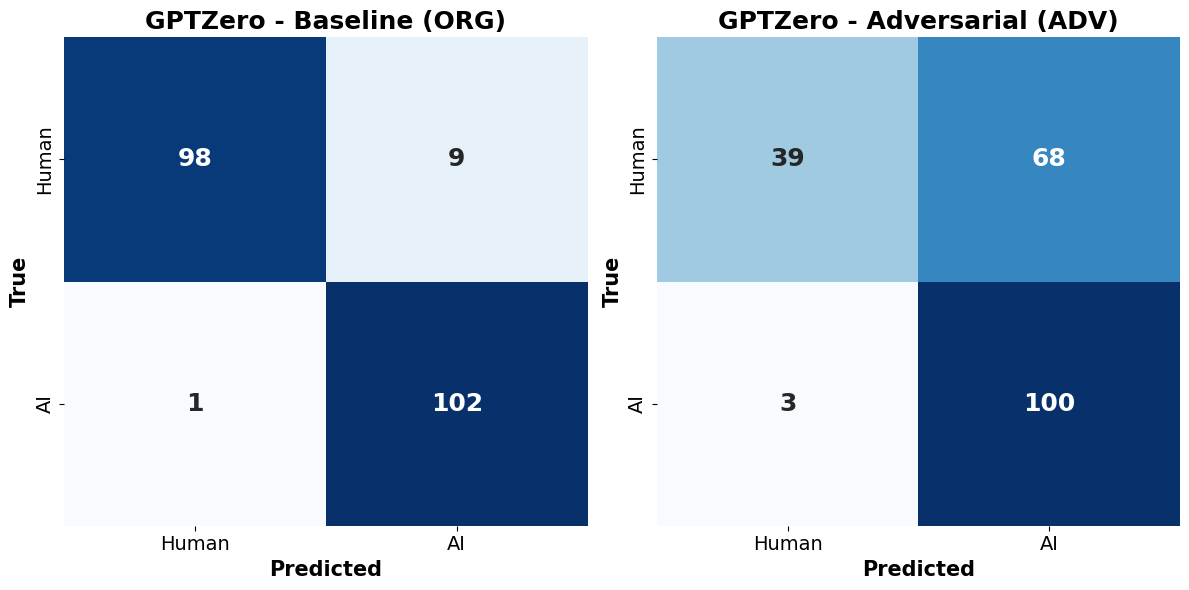

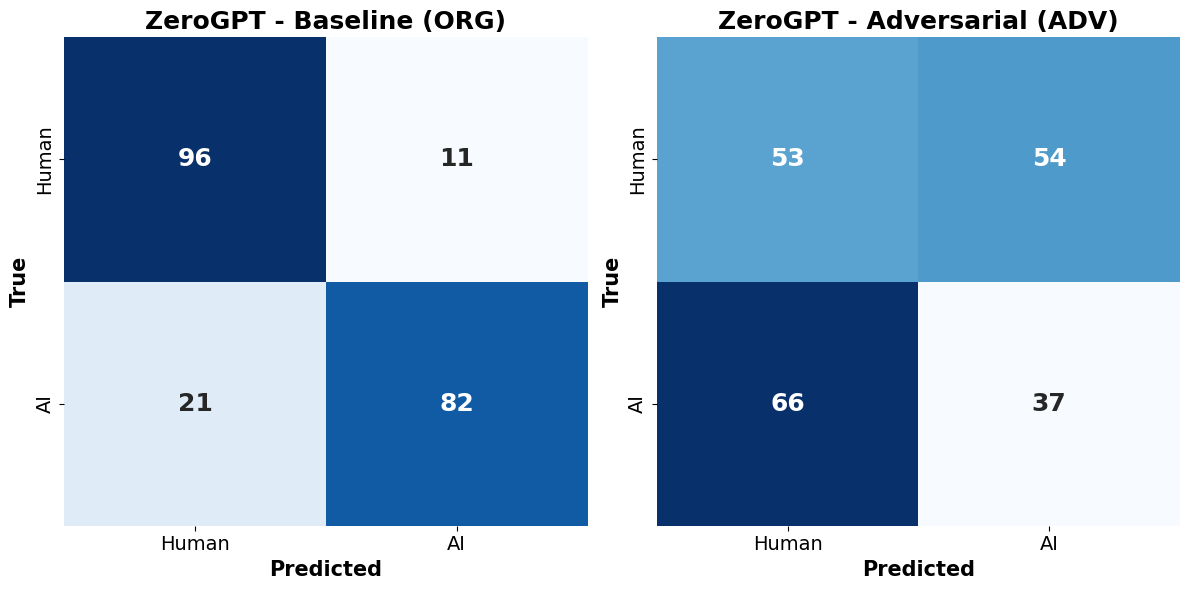

In [67]:
# --- Cell 5: Side-by-side Confusion Matrices with Larger Fonts ---
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot confusion matrix with enhanced fonts
def plot_conf_matrix(cm, ax, title):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Human", "AI"], yticklabels=["Human", "AI"],
                ax=ax, cbar=False, annot_kws={"size":18, "weight":"bold"})
    ax.set_title(title, fontsize=18, fontweight='bold')
    ax.set_ylabel("True", fontsize=15, fontweight='bold')
    ax.set_xlabel("Predicted", fontsize=15, fontweight='bold')
    # Increase tick label font size
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

# Plot GPTZero confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(12,6))
plot_conf_matrix(results["GPTZero"]["ORG"]["cm"], axes[0], "GPTZero - Baseline (ORG)")
plot_conf_matrix(results["GPTZero"]["ADV"]["cm"], axes[1], "GPTZero - Adversarial (ADV)")
plt.tight_layout()
plt.show()

# Plot ZeroGPT confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(12,6))
plot_conf_matrix(results["ZeroGPT"]["ORG"]["cm"], axes[0], "ZeroGPT - Baseline (ORG)")
plot_conf_matrix(results["ZeroGPT"]["ADV"]["cm"], axes[1], "ZeroGPT - Adversarial (ADV)")
plt.tight_layout()
plt.show()


In [47]:
# --- Cell 6: Corrected McNemar’s Test (ORG vs ADV) ---
from statsmodels.stats.contingency_tables import mcnemar

for det, df in detectors.items():
    # Map labels to numeric
    y_true = df["source"].map({"Human": 0, "AI": 1}).values
    y_org = df["detector_result_ORG"].map({"Human": 0, "AI": 1}).values
    y_adv = df["detector_results_ADV"].map({"Human": 0, "AI": 1}).values

    # Compute 2x2 contingency table properly
    both_correct = np.sum((y_org == y_true) & (y_adv == y_true))
    both_wrong   = np.sum((y_org != y_true) & (y_adv != y_true))
    org_only_wrong = np.sum((y_org != y_true) & (y_adv == y_true))  # discordant
    adv_only_wrong = np.sum((y_org == y_true) & (y_adv != y_true))  # discordant

    table = [[both_correct, org_only_wrong],
             [adv_only_wrong, both_wrong]]

    # Run McNemar test
    result = mcnemar(table, exact=False)

    print(f"{det} McNemar’s test: statistic={result.statistic}, p-value={result.pvalue}")


GPTZero McNemar’s test: statistic=58.140625, p-value=2.4403438635798453e-14
ZeroGPT McNemar’s test: statistic=137.06293706293707, p-value=1.168230830266154e-31


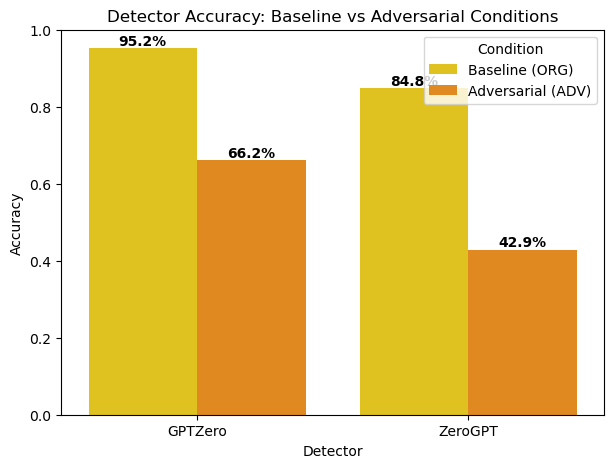

In [86]:
# --- Cell 7: Detector Accuracy Comparison (Baseline vs Adversarial) with bright colors and % labels ---
acc_data = []
for det in results:
    acc_org = results[det]["ORG"]["accuracy"]
    acc_adv = results[det]["ADV"]["accuracy"]
    acc_data.append([det, "Baseline (ORG)", acc_org])
    acc_data.append([det, "Adversarial (ADV)", acc_adv])

acc_df = pd.DataFrame(acc_data, columns=["Detector", "Condition", "Accuracy"])

# Bright, distinct colors
palette = {
   "Baseline (ORG)": "#FFD700",  # sun yellow / gold
    "Adversarial (ADV)": "#FF8C00" # bright orange / dark orange
}

plt.figure(figsize=(7,5))
sns.barplot(x="Detector", y="Accuracy", hue="Condition", data=acc_df, palette=palette)

# Annotate bars with percentages
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f"{height:.1%}",
                       (p.get_x() + p.get_width() / 2., height),
                       ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

plt.title("Detector Accuracy: Baseline vs Adversarial Conditions")
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.xlabel("Detector")
plt.show()


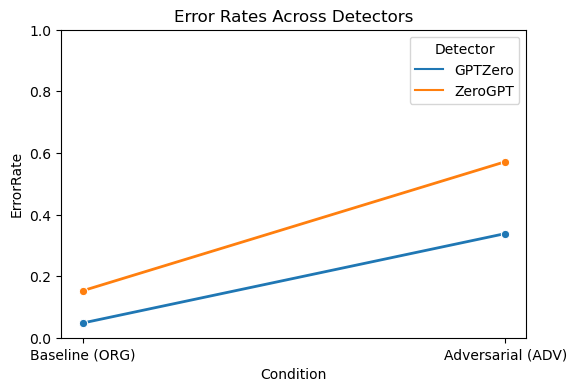

In [45]:
# --- Cell 8: Error Rate Reduction Plot ---
err_data = []
for det in results:
    org_err = 1 - results[det]["ORG"]["accuracy"]
    adv_err = 1 - results[det]["ADV"]["accuracy"]
    err_data.append([det, "Baseline (ORG)", org_err])
    err_data.append([det, "Adversarial (ADV)", adv_err])

err_df = pd.DataFrame(err_data, columns=["Detector", "Condition", "ErrorRate"])

plt.figure(figsize=(6,4))
sns.lineplot(x="Condition", y="ErrorRate", hue="Detector", data=err_df,
             marker="o", linewidth=2)
plt.title("Error Rates Across Detectors")
plt.ylim(0,1)
plt.show()


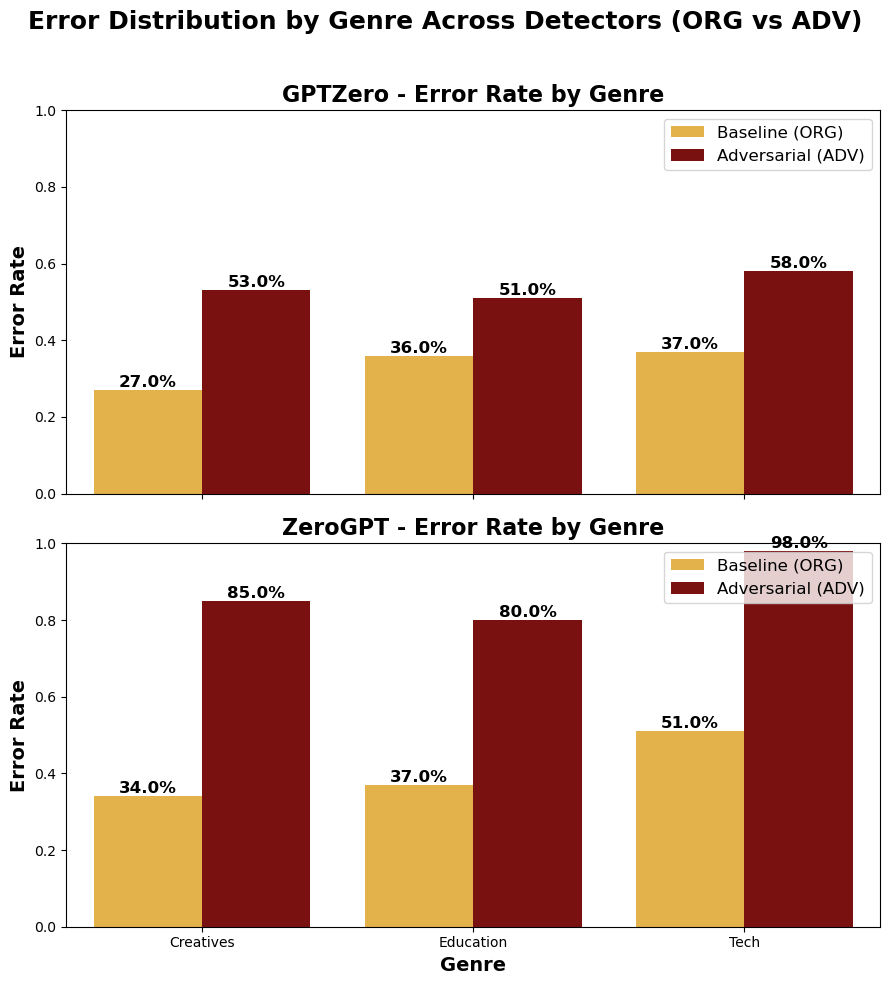

In [101]:
# --- Cell 9: Stacked Genre Error Distribution with Enhanced Fonts ---
import matplotlib.pyplot as plt
import seaborn as sns

# Bright, distinct palette
palette_conditions = {
    "Baseline (ORG)": "#FDBB30",   # golden yellow
    "Adversarial (ADV)": "#8B0000" # orange
}

fig, axes = plt.subplots(2, 1, figsize=(9,10), sharex=True)

for i, (det, df) in enumerate(detectors.items()):
    # Map true/pred
    df["true"] = df["source"].map({"Human":0,"AI":1})
    df["pred_org"] = df["detector_result_ORG"].map({"Human":0,"AI":1})
    df["pred_adv"] = df["detector_results_ADV"].map({"Human":0,"AI":1})

    # Error flags
    df["error_org"] = df["true"] != df["pred_org"]
    df["error_adv"] = df["true"] != df["pred_adv"]

    # Compute mean error per genre
    genre_errors = df.groupby("genre")[["error_org","error_adv"]].mean().reset_index()
    genre_errors = genre_errors.melt(id_vars="genre", value_vars=["error_org","error_adv"],
                                     var_name="Condition", value_name="ErrorRate")
    genre_errors["Condition"] = genre_errors["Condition"].replace({"error_org":"Baseline (ORG)",
                                                                   "error_adv":"Adversarial (ADV)"})

    # Plot barplot
    sns.barplot(x="genre", y="ErrorRate", hue="Condition", data=genre_errors,
                ax=axes[i], palette=palette_conditions)
    
    # Titles and labels
    axes[i].set_title(f"{det} - Error Rate by Genre", fontsize=16, fontweight='bold')
    axes[i].set_ylabel("Error Rate", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("")  # x-label on bottom plot only
    axes[i].set_ylim(0,1)

    # Annotate bars with percentages (bigger font)
    for p in axes[i].patches:
        height = p.get_height()
        axes[i].annotate(f"{height:.1%}", 
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# X-axis label and legend
axes[1].set_xlabel("Genre", fontsize=14, fontweight='bold')
axes[0].legend(fontsize=12, loc='upper right')
axes[1].legend(fontsize=12, loc='upper right')

plt.suptitle("Error Distribution by Genre Across Detectors (ORG vs ADV)", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


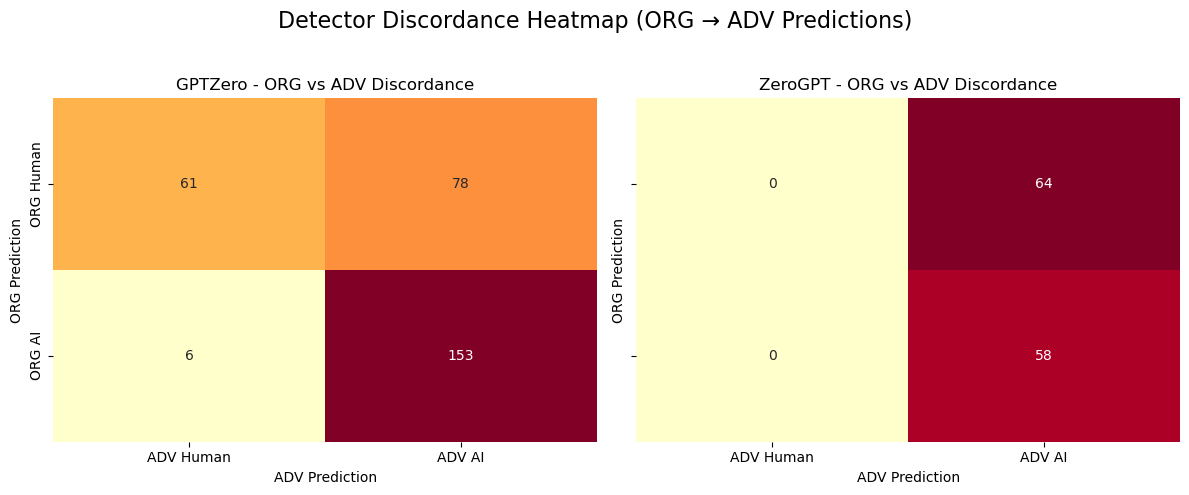

In [56]:
# --- Discordance Heatmap for Both Detectors (Safe 2x2) ---
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

for i, (det, df) in enumerate(detectors.items()):
    # Map labels
    y_org = df["detector_result_ORG"].map({"Human":0,"AI":1})
    y_adv = df["detector_results_ADV"].map({"Human":0,"AI":1})

    # Create 2x2 matrix safely
    matrix = pd.crosstab(y_org, y_adv).reindex(index=[0,1], columns=[0,1], fill_value=0)
    matrix.index = ['ORG Human','ORG AI']
    matrix.columns = ['ADV Human','ADV AI']

    # Heatmap
    sns.heatmap(matrix, annot=True, fmt="d", cmap="YlOrRd", ax=axes[i], cbar=False)
    axes[i].set_title(f"{det} - ORG vs ADV Discordance")
    axes[i].set_xlabel("ADV Prediction")
    axes[i].set_ylabel("ORG Prediction")

plt.suptitle("Detector Discordance Heatmap (ORG → ADV Predictions)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


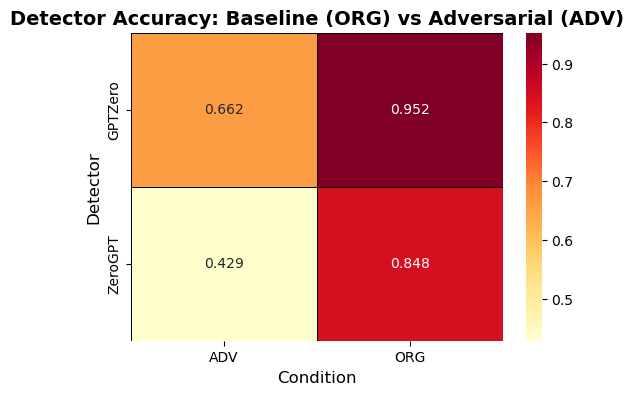

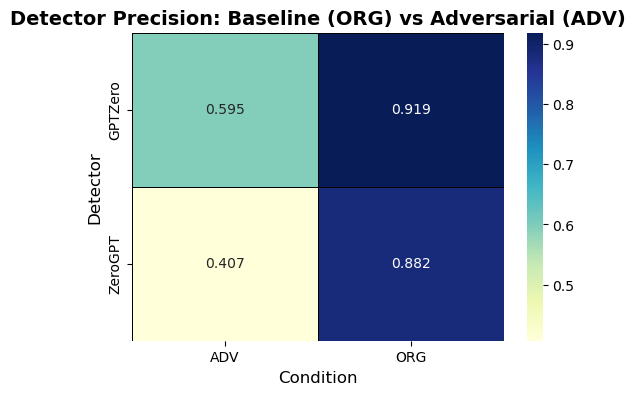

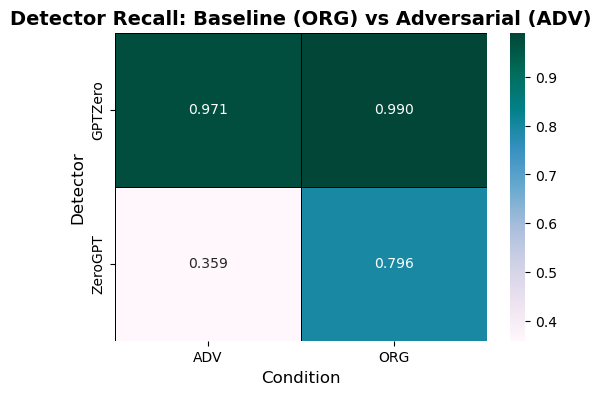

In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compile metrics into a DataFrame for heatmap
data = []
for det, conds in results.items():
    for cond_name, metrics in conds.items():
        data.append({
            "Detector": det,
            "Condition": cond_name,
            "Accuracy": metrics["accuracy"],
            "Precision": metrics["precision"],
            "Recall": metrics["recall"]
        })

df_metrics = pd.DataFrame(data)

# Pivot table for heatmap (metrics as columns)
heatmap_df = df_metrics.pivot(index="Detector", columns="Condition", values="Accuracy")
# You can repeat for Precision or Recall by changing `values="Accuracy"`

# Plot heatmap for Accuracy
plt.figure(figsize=(6,4))
sns.heatmap(heatmap_df, annot=True, fmt=".3f", cmap="YlOrRd", linewidths=0.5, linecolor='black')
plt.title("Detector Accuracy: Baseline (ORG) vs Adversarial (ADV)", fontsize=14, fontweight='bold')
plt.ylabel("Detector", fontsize=12)
plt.xlabel("Condition", fontsize=12)
plt.show()

# Optional: repeat for Precision
heatmap_df_prec = df_metrics.pivot(index="Detector", columns="Condition", values="Precision")
plt.figure(figsize=(6,4))
sns.heatmap(heatmap_df_prec, annot=True, fmt=".3f", cmap="YlGnBu", linewidths=0.5, linecolor='black')
plt.title("Detector Precision: Baseline (ORG) vs Adversarial (ADV)", fontsize=14, fontweight='bold')
plt.ylabel("Detector", fontsize=12)
plt.xlabel("Condition", fontsize=12)
plt.show()

# Optional: repeat for Recall
heatmap_df_rec = df_metrics.pivot(index="Detector", columns="Condition", values="Recall")
plt.figure(figsize=(6,4))
sns.heatmap(heatmap_df_rec, annot=True, fmt=".3f", cmap="PuBuGn", linewidths=0.5, linecolor='black')
plt.title("Detector Recall: Baseline (ORG) vs Adversarial (ADV)", fontsize=14, fontweight='bold')
plt.ylabel("Detector", fontsize=12)
plt.xlabel("Condition", fontsize=12)
plt.show()


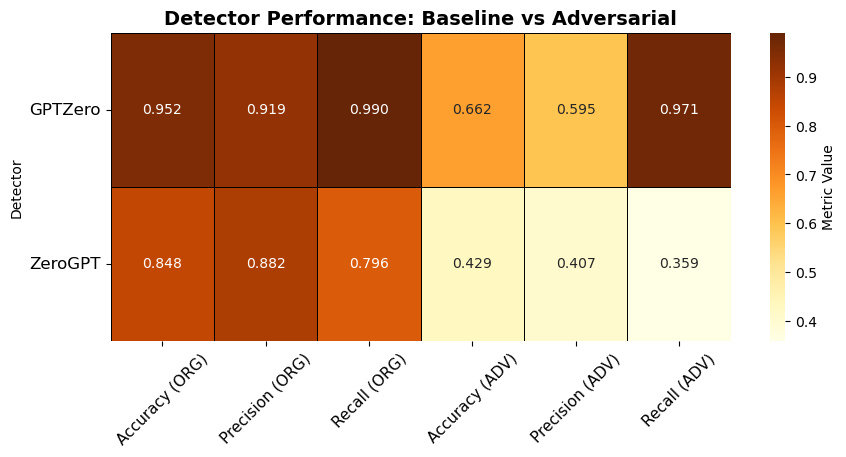

In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare combined DataFrame
data = []
for det, conds in results.items():
    row = {"Detector": det}
    for cond_name, metrics in conds.items():
        for metric in ["accuracy", "precision", "recall"]:
            row[f"{metric.capitalize()} ({cond_name})"] = metrics[metric]
    data.append(row)

df_combined = pd.DataFrame(data)
df_combined.set_index("Detector", inplace=True)

# Plot heatmap
plt.figure(figsize=(10,4))
sns.heatmap(df_combined, annot=True, fmt=".3f", cmap="YlOrBr", linewidths=0.5, linecolor='black', cbar_kws={'label':'Metric Value'})
plt.title("Detector Performance: Baseline vs Adversarial", fontsize=14, fontweight='bold')
plt.yticks(rotation=0, fontsize=12)
plt.xticks(rotation=45, fontsize=11)
plt.show()


C:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_18800\2186952539.py:43: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.95])


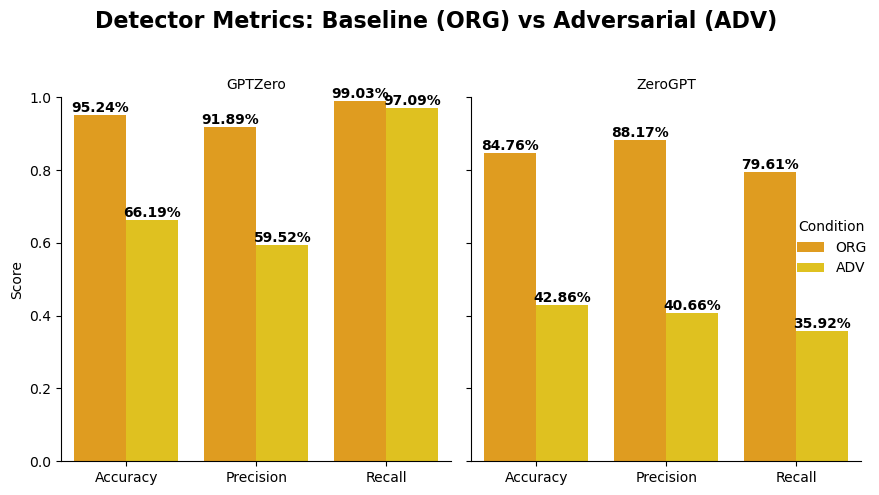

In [89]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare long-format dataframe for plotting
data = []
for det, conds in results.items():
    for cond_name, metrics in conds.items():
        for metric in ["accuracy", "precision", "recall"]:
            data.append({
                "Detector": det,
                "Condition": cond_name,
                "Metric": metric.capitalize(),
                "Value": metrics[metric]
            })

df_plot = pd.DataFrame(data)

# Set bright, professional colors
palette = {"ORG": "#FFA500", "ADV": "#FFD700"}  # Sun yellow and bright orange

# Plot grouped barplot with detectors as separate facets
g = sns.catplot(
    data=df_plot,
    x="Metric", y="Value", hue="Condition",
    col="Detector",
    kind="bar",
    palette=palette,
    height=5, aspect=0.8
)

# Annotate bars
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2%}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

g.set_titles("{col_name}")
g.set_axis_labels("", "Score")
g.set(ylim=(0,1))
plt.suptitle("Detector Metrics: Baseline (ORG) vs Adversarial (ADV)", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
